# Homework #1 (Due 09/02/2026, 11:59pm)

**ELEC70122: ML for Safety Critical Decision-Making**<br>
**Instructor: Sonali Parbhoo**<br>
**Fall 2026**

**Name: Chi-Huang Liu** 

### Instructions:

**Submission Format:** Use this notebook as a template to complete your homework. Please intersperse text blocks (using Markdown cells) amongst `python` code and results -- format your submission for maximum readability. Your assignments will be graded for correctness as well as clarity of exposition and presentation -- a “right” answer by itself without an explanation or is presented with a difficult to follow format will receive no credit.

**Code Check:** Before submitting, you must do a "Restart and Run All" under "Kernel" in the Jupyter or colab menu. ***Portions of your submission that contains syntactic or run-time errors will not be graded***.

**Libraries and packages:** Unless a problems specifically asks you to implement from scratch, you are welcomed to use any `python` library package in the standard Anaconda distribution.

In [1]:
### Import basic libraries
import numpy as np
import pandas as pd
import sklearn as sk
from scipy.stats import multivariate_normal
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
SEED = 6067892
rng = np.random.default_rng(SEED)

In [3]:
def get_posterior_samples(
    prior_var, noise_var, x_matrix, y_matrix, x_test_matrix, samples=100
):
    """Function to generate posterior predictive samples for Bayesian linear regression model"""
    prior_variance = np.diag(prior_var * np.ones(x_matrix.shape[1]))
    prior_precision = np.linalg.inv(prior_variance)

    joint_precision = prior_precision + x_matrix.T.dot(x_matrix) / noise_var
    joint_variance = np.linalg.inv(joint_precision)
    joint_mean = joint_variance.dot(x_matrix.T.dot(y_matrix)) / noise_var

    # sampling 100 points from the posterior
    posterior_samples = np.random.multivariate_normal(
        joint_mean.flatten(), joint_variance, size=samples
    )

    # take posterior predictive samples
    posterior_predictions = np.dot(posterior_samples, x_test_matrix.T)
    posterior_predictive_samples = posterior_predictions[
        np.newaxis, :, :
    ] + np.random.normal(
        0,
        noise_var**0.5,
        size=(100, posterior_predictions.shape[0], posterior_predictions.shape[1]),
    )
    posterior_predictive_samples = posterior_predictive_samples.reshape(
        (100 * posterior_predictions.shape[0], posterior_predictions.shape[1])
    )
    return posterior_predictions, posterior_predictive_samples


def generate_data(number_of_points=10, noise_variance=0.3, seed=SEED):
    """Function for generating toy regression data"""
    rng = np.random.default_rng(seed)

    # training x
    x_train = np.hstack(
        (np.linspace(-1, -0.5, number_of_points), np.linspace(0.5, 1, number_of_points))
    )
    # function relating x and y
    f = lambda x: 3 * x**3
    # y is equal to f(x) plus gaussian noise
    y_train = f(x_train) + rng.normal(0, noise_variance**0.5, 2 * number_of_points)
    x_test = np.array(list(set(list(np.hstack((np.linspace(-1, 1, 200), x_train))))))
    x_test = np.sort(x_test)
    return x_train, y_train, x_test

## Part I: Maximum Likelihood Estimators for Polynomial Regression

In this problem, you are given a function, `generate_data`, to generate toy datasets with a single predictor $X$ representing patient age (normalized) and a single outcome $y$ representing diastolic blood pressure (normalized and rescaled), and your task is to fit polynomial models to the data. That is, assume that the outcome $y$ can be modeled by the following process:

\begin{align}
y &= f(x) + \epsilon = w_0 + w_1x + w_2x^2 + \ldots + w_Dx^D + \epsilon, \quad \epsilon \sim \mathcal{N}(0, 0.3)
\end{align}

where the $w_d$, the *parameters* of the function $f$, are unknown constants, and the degree $D$ is a hyperparameter.


You'll notice that in these datasets, the test input is sampled from a different distribution that the training input: the training input has a gap, there are no training input values in [-0.5, 0.5], where as the test input are sampled across [-1, 1]. This change of the distributions over the $x$-values between training and test is called **covariate shift**.

These toy datasets simulate a very common problem in machine learning: models are fitted on training data, but during deployment they are given data dissimlar to the training data (i.e. the model encounters covariate shift). As such, you should treat `x_train`, `y_train` as data available during model development and evaluation, and `x_test` as data you encounter during model deployment.

The goal in this assignment is to explore how to manage the risk of a deployed model under covariate shift. The ideas developed in this assignment will become a major focus in the latter part of the course and the foundation of an active area of current research.

1. **(Effect of Model Complexity)** Generate a toy dataset with 40 observations (set the parameter `number_of_points=20` for `generate_data`, since twice the number of `number_of_points` will be generated), then  visualize the fit of MLE polynomial models, with degrees $D = [1, 3, 5, 10, 15, 20, 50, 100]$ - you should train on `x_train` and **visualize by predicting on `x_test` provided by the data generating function (`x_test` is a larger set of test points that includes `x_train`)**. You'll need to be thoughtful about your visualization so that these different models can be visually compared in a meaningful way. <br><br>
Discuss the effect of the choice of polynomial degree on the fit of the model (concretely describe why certaint choices are unideal in the context of the problem).

---
**[solution]** <br><br>
When D <= 5, the prediction is smooth on the unseen data range [-0.5, 5]. When D = 10, the prediction on the unseen data range starts to surge. For D >= 15, the the prediction on the unseen data range becomes extremely low. Note that for D = 100, even on the training data range, the prediction oscillates. <br><br>
In the blood pressure prediction context, failed to generalize on the unseen range will cause unreasonable predictions, like blood pressure maybe impossibly low for human beings, or false diagnosis for hypotension. <br><br>

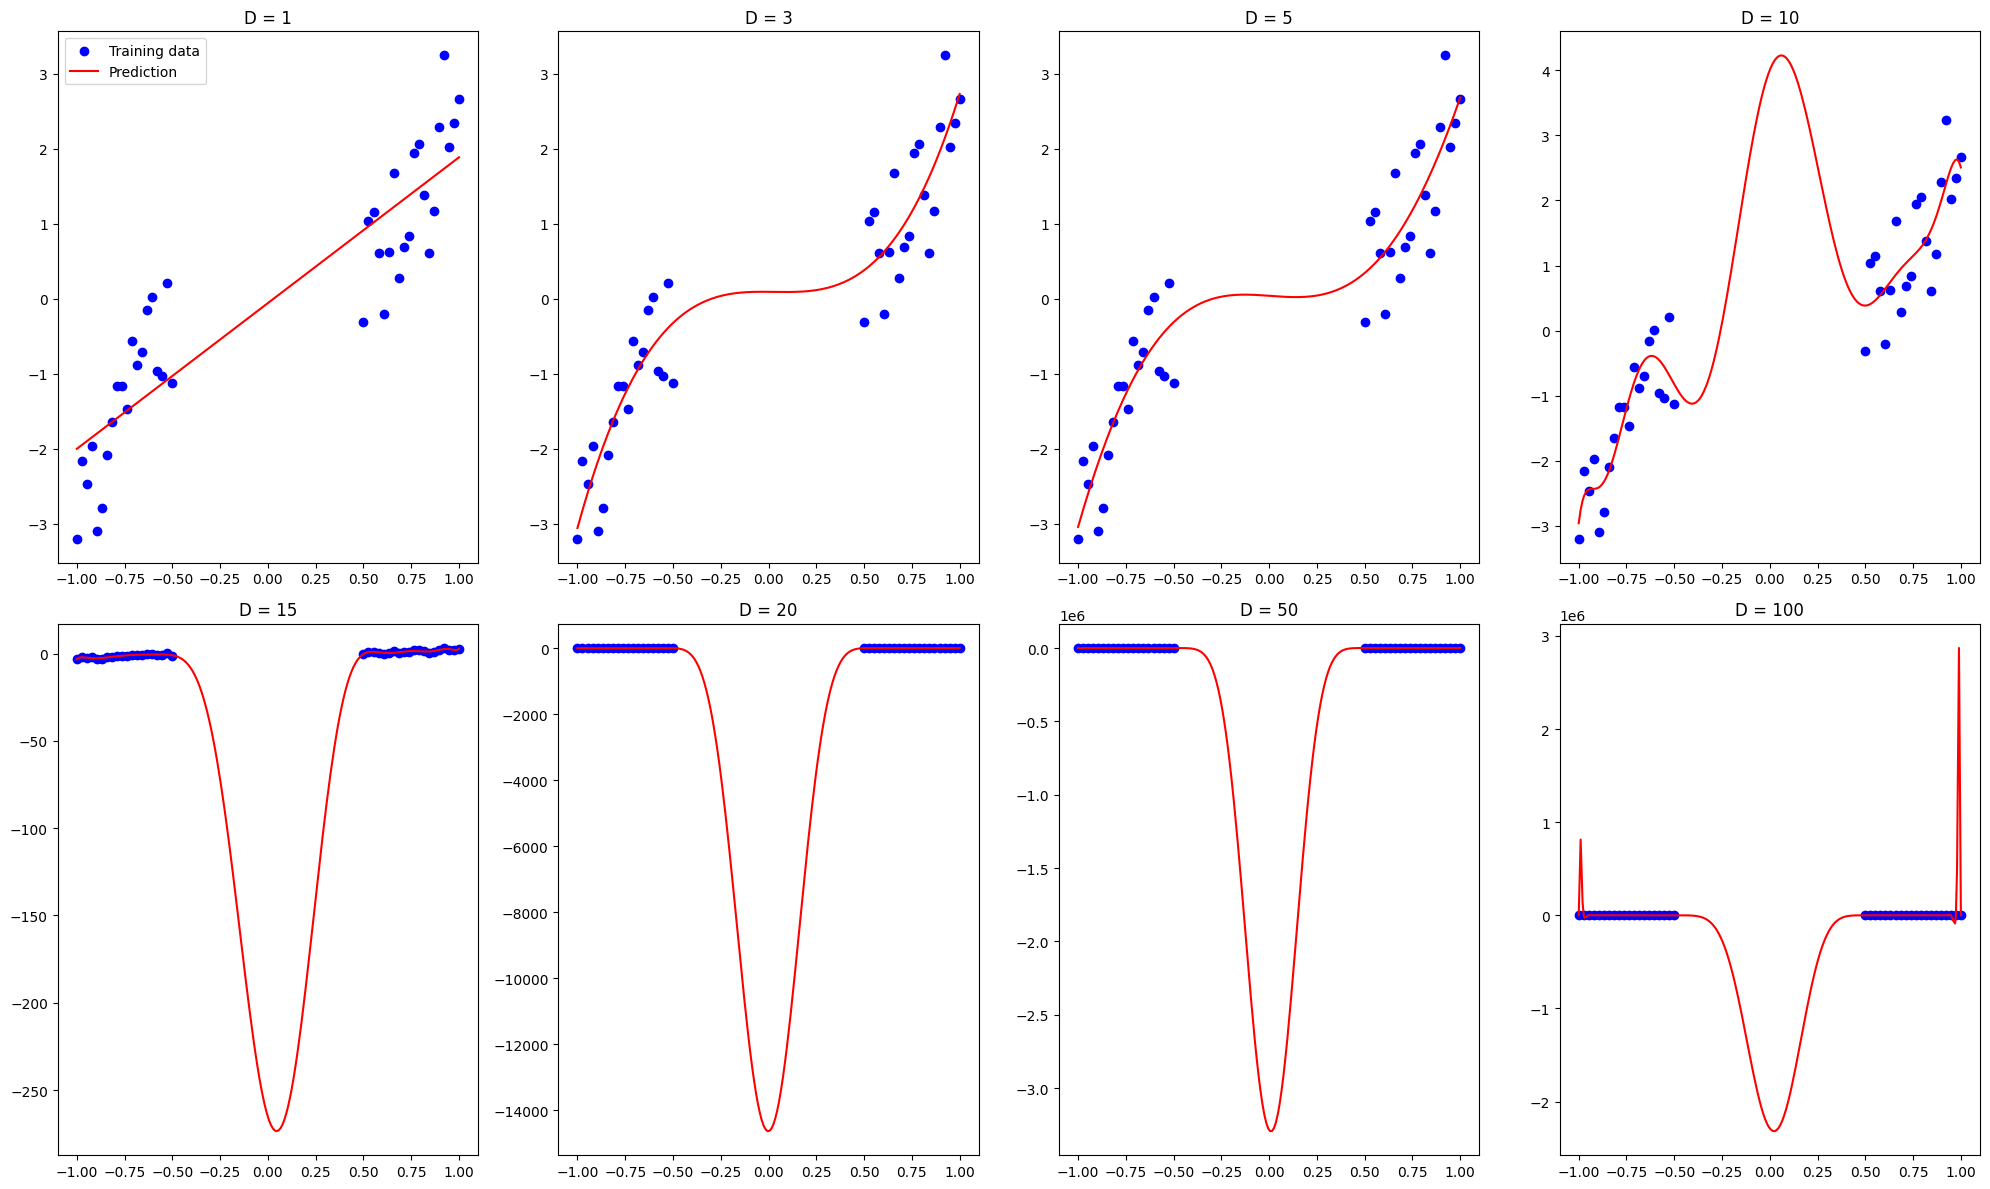

In [4]:
x_train, y_train, x_test = generate_data(number_of_points=20, noise_variance=0.3)

Ds = [1, 3, 5, 10, 15, 20, 50, 100]

fig, axs = plt.subplots(2, 4, figsize=(20, 12))
axs = axs.flatten()


def fit_polynomial_linear_regression(
    x_train, y_train, D
) -> tuple[PolynomialFeatures, LinearRegression]:
    x_train_reshaped = x_train.reshape(-1, 1)

    y_train_reshaped = y_train.reshape(-1, 1)

    polynomial = PolynomialFeatures(D)
    x_train_transformed = polynomial.fit_transform(x_train_reshaped)
    model = LinearRegression()
    model.fit(x_train_transformed, y_train_reshaped)
    return polynomial, model


def predict_polynomial_linear_regression(x_test, polynomial, model) -> np.ndarray:
    x_test_reshaped = x_test.reshape(-1, 1)
    x_test_transformed = polynomial.transform(x_test_reshaped)
    pred = model.predict(x_test_transformed)
    return pred


for i, D in enumerate(Ds):
    polynomial, model = fit_polynomial_linear_regression(x_train, y_train, D)
    pred = predict_polynomial_linear_regression(x_test, polynomial, model)

    axs[i].scatter(x_train, y_train, color="blue", label="Training data")
    axs[i].plot(x_test, pred, color="red", label="Prediction")
    axs[i].set_title(f"D = {D}")
    if i == 0:
        axs[i].legend()

plt.tight_layout()
plt.show()

2. **(Model Selection)** Later in the course, we will study a number of metrics commonly used for selecting between different MLE models. All of these metric essentially encode Occam's Razor: select the minimal complexity of model that satisfies some pre-determined modeling goal. <br><br>
For now, a very simple method for selecting the optimal degree is via cross-validation (by bootstrap):

  - 1. randomly sample two datasets, `x_train`, `x_valid`, from the data generating function: one for training and one for validation. Fit an MLE  polynomial model of degree $d$ on the training data and evaluate its performance on the validation data. Over $S$ number of such randomly sampled pairs of datasets, average the model's validation performance.
  - 2. plot the validation score as a function of model complexity, the polynomial degree $d$.
  - 3. based on the plot, select the the minimal degree that achieves a high average validation performance (i.e. look for the 'elbow' of the plot).

  Explain why performing model selection by cross-validation mitigates the risk of choosing an undesirable polynomial (identified in Problem 1)?<br><br>
  Implement model selection by cross-validation for the toy dataset generated in Problem 1 using MSE as your performance metric and select an optimal degree from $D=[1,3,5,10,15,20,50,100]$.

---
**[solution]** <br><br>
Using cross-validation prevent models overfitting on the training data. For those high-degree polynomial models, they do not perform will on the validation set since they are more likely to overfit.<br><br>
The elbow plot of cross-validation MSEs shows that D = 3 is the ideal choice, which draws the similar conclusion as question 1.

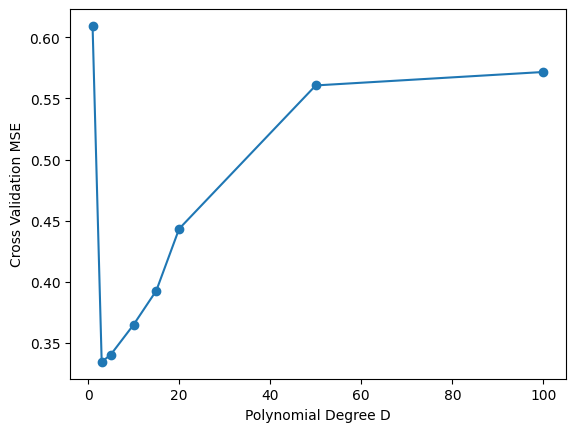

In [5]:
from sklearn.metrics import mean_squared_error

seeds = rng.integers(0, 10000, size=10)

cv_results = {}
for D in [1, 3, 5, 10, 15, 20, 50, 100]:
    MSEs = []
    for seed in seeds:
        x_train, y_train, _ = generate_data(
            number_of_points=20, noise_variance=0.3, seed=seed
        )
        x_valid, y_valid, _ = generate_data(
            number_of_points=20, noise_variance=0.3, seed=seed + 1
        )

        polynomial, model = fit_polynomial_linear_regression(x_train, y_train, D)
        pred = predict_polynomial_linear_regression(x_valid, polynomial, model)

        MSEs.append(mean_squared_error(y_valid, pred.flatten()))

    mse_cv = np.mean(MSEs)
    cv_results[D] = mse_cv


plt.plot(list(cv_results.keys()), list(cv_results.values()), marker="o")
plt.xlabel("Polynomial Degree D")
plt.ylabel("Cross Validation MSE")
plt.show()

3. **(Uncertainty Estimation)** We often use the bootstrap predictive uncertainty of MLE models as an indicator of our confidence in the model's output. Increasingly, in practice, decisions making are deferred to human experts when the model's predictive uncertainty is too high. <br><br>
Given your understanding of the dataset (`x_train` and `x_test`), describe what the model uncertainty ***should*** ideally look like across the input space (i.e. if you plotted the model uncertainty as a function of $x$, what would it look like)? Justify your answer: consider the context of the problem - the test input has undergone covariate shift and is dissmilar to the training input, what kind of uncertainty would help you mitigate risk under this condition?<br><br>
A common practice for estimating predictive uncertainty is to fit a large number of (bootstrap) models on the training data (this collection of models is called an **ensemble**), then, at an input $x$, use the variance of the ensemble predictions to estimate the uncertainty at $x$. Plot the 95% predictive interval of 200 bootstrap MLE polynomial models for each degree $D=[1,3,5,10,15,20,50,100]$, arrange your plots as  subplots in a single figure. For which polynomial degree do you obtain the predictive uncertainty that is most ideal (according to your description above)? Is this the degree you selected in Problem 2? Explain why you would or would not expect the optimal degree in Problem 2 to yield the most ideal uncertainty estimate.<br><br>
Make the same plots the 95% predictive intervals for degrees $D=[1,3,5,10,15,20,50,100]$, with models fitted on larger training datasets - set `number_of_points` to 50, 100, 500, 1000 (arrange all these plots in a single figure). What is happening to the predictions of the ensemble in the training data rich region? What is happening to the predictions of the ensemble in the training data poor region? Are these expected behaviours (relate what you see in both cases to the asymptotic properties of MLE)?
<br><br>
When the training data is abundant (`number_of_points=1000`), are any of the 95% predictive intervals ideal (according to your description above)? What does this imply about the feasibility of using the variance of the ensemble predictions to estimate predictive uncertainty at an input $x$?

---
**[solution]** <br><br>
Ideally, the uncertainty should be higher in the unseen test data range [-0.5, 0.5]. So the interval should be narrower when we have training data, and wider when there's no data. Epistemic Uncertainty can help us the mitigate the risk since it can represent the lack of knowledge/data.<br><br>Accordingly, D = 5 is the most ideal choice. The choice is different from Problem 2, since in Problem 2 we only consider the data we can see when doing cross-validation. Here we consider the data we didn't see in training, and have some assumption about the uncertainty.<br><br>

On data rich regions, as the number of observation increases, the uncertainty bounds becomes narrower, even the degree D is high. However, on data poor regions, is the degree D is high, the uncertainty bounds stays wide. This is consistent with the asymptotic properties of MLE, which says that the variance of the MLE decreases at a rate of approximately $1/n$. <br><br>

When the training data is abundant, all the 95% predictive intervals are not ideal: for models with low degree D, they seem to be over confident on the regions with on training data. When degree D is high, they are numerically unstable and the uncertainty bounds are extremely wide. This implies that if using the variance of the ensemble predictions to estimate predictive uncertainty, simple models may be overconfident, and complex models still suffer from unstable of uncertainty estimation.

This block shows the result of bootstrapping with 40 data

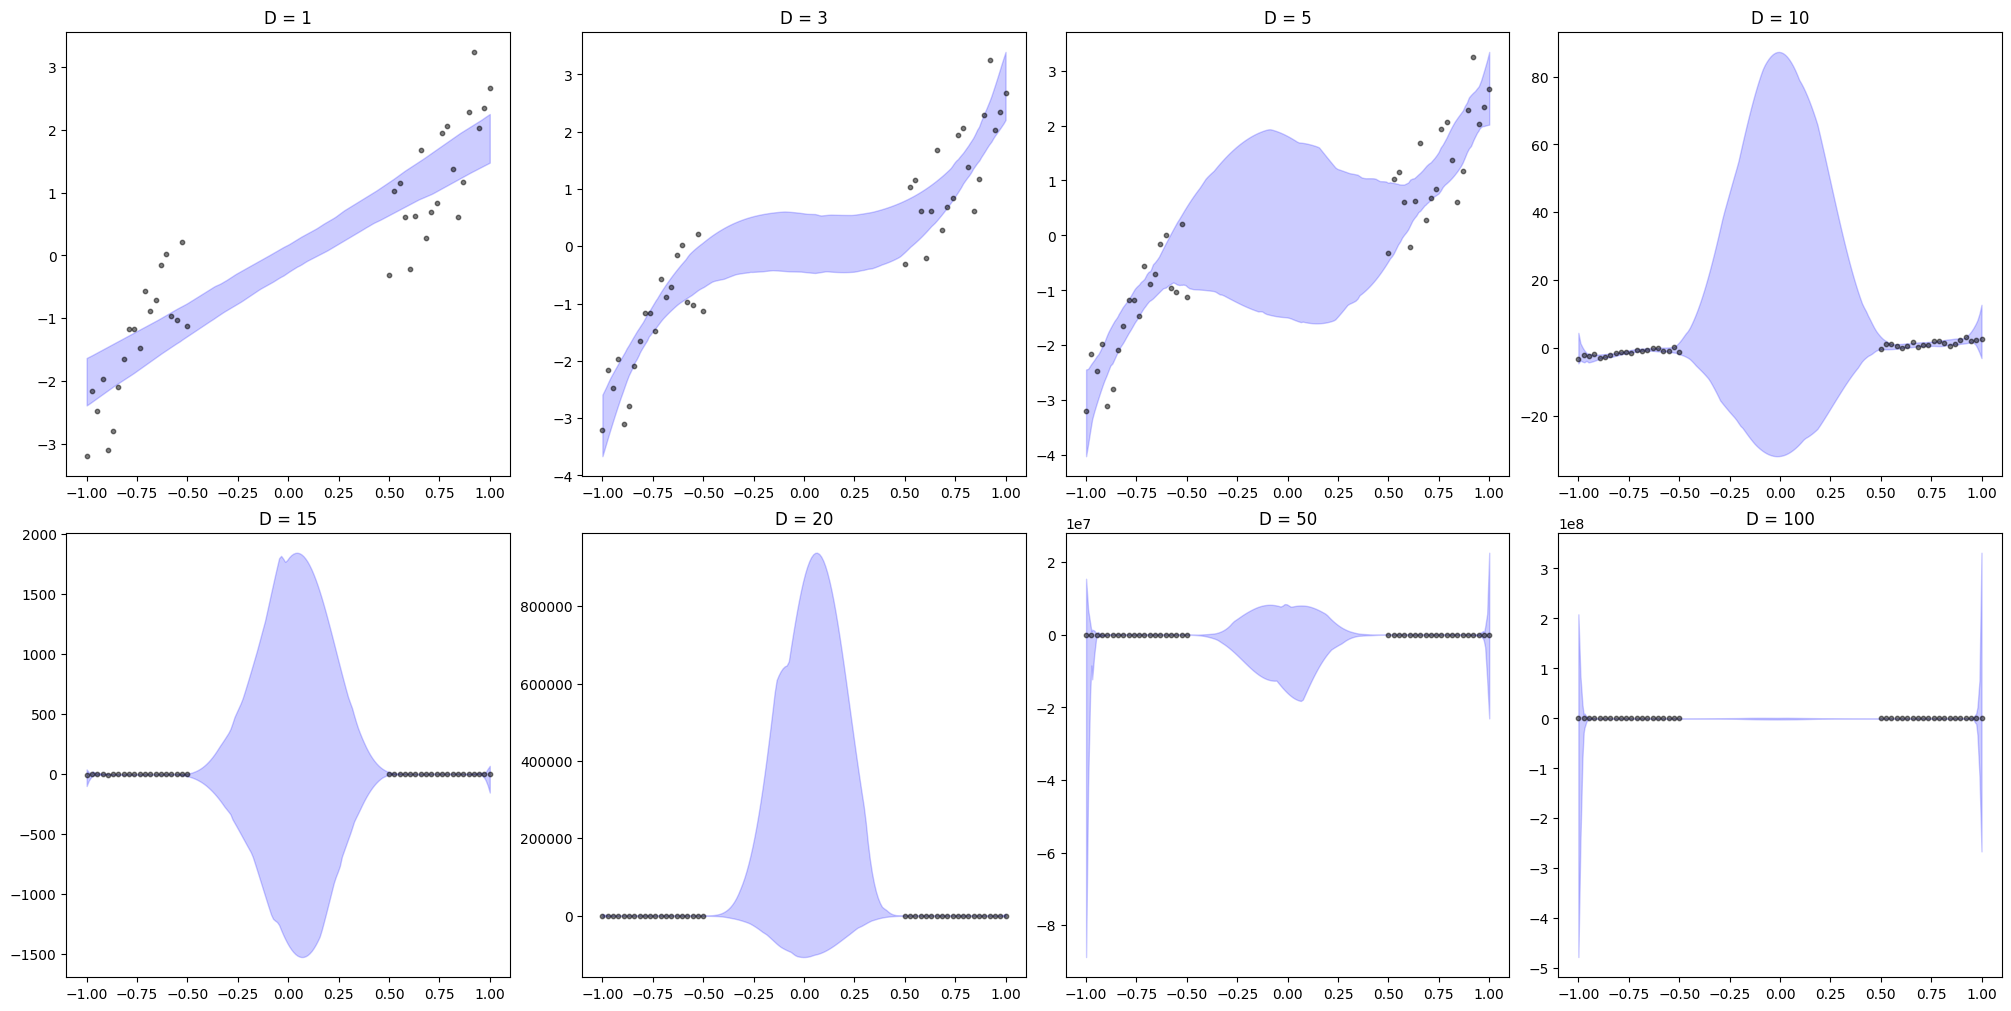

In [6]:
def bootstrap(x, y, seed) -> tuple[np.ndarray, np.ndarray]:
    rng = np.random.default_rng(seed)
    n = x.shape[0]
    indices = rng.integers(0, n, size=n)
    return x[indices], y[indices]


def get_95_interval_bounds(
    num_bootstrap_models,
    x_train,
    y_train,
    x_test,
    seeds,
    D,
    fit_func=fit_polynomial_linear_regression,
    **fit_func_kwargs,
) -> tuple[np.ndarray, np.ndarray]:
    preds = np.empty((num_bootstrap_models, x_test.shape[0]))
    for i, seed in enumerate(seeds):
        x_train_bs, y_train_bs = bootstrap(x_train, y_train, seed)
        polynomial, model = fit_func(x_train_bs, y_train_bs, D, **fit_func_kwargs)
        pred = predict_polynomial_linear_regression(x_test, polynomial, model)
        pred = pred.flatten()
        preds[i, :] = pred

    pred_pr2_5 = np.percentile(preds, 2.5, axis=0)
    pred_pr97_5 = np.percentile(preds, 97.5, axis=0)
    return pred_pr2_5, pred_pr97_5


num_bootstrap_models = 200
seeds = rng.integers(0, 10000, size=num_bootstrap_models)
x_train, y_train, x_test = generate_data(number_of_points=20)
Ds = [1, 3, 5, 10, 15, 20, 50, 100]

fig = plt.figure(figsize=(20, 10), constrained_layout=True)
axs = fig.subplots(2, 4)
axs = axs.flatten()

for idx, D in enumerate(Ds):
    pred_pr2_5, pred_pr97_5 = get_95_interval_bounds(
        num_bootstrap_models, x_train, y_train, x_test, seeds, D
    )

    ax = axs[idx]
    ax.fill_between(
        x_test,
        pred_pr2_5,
        pred_pr97_5,
        alpha=0.2,
        color="blue",
        label="95% Predictive Interval",
    )
    ax.scatter(x_train, y_train, color="black", s=10, alpha=0.5)

    ax.set_title(f"D = {D}")

plt.show()

This block shows the result of bootstrapping with 50, 100, 500, 1000 data

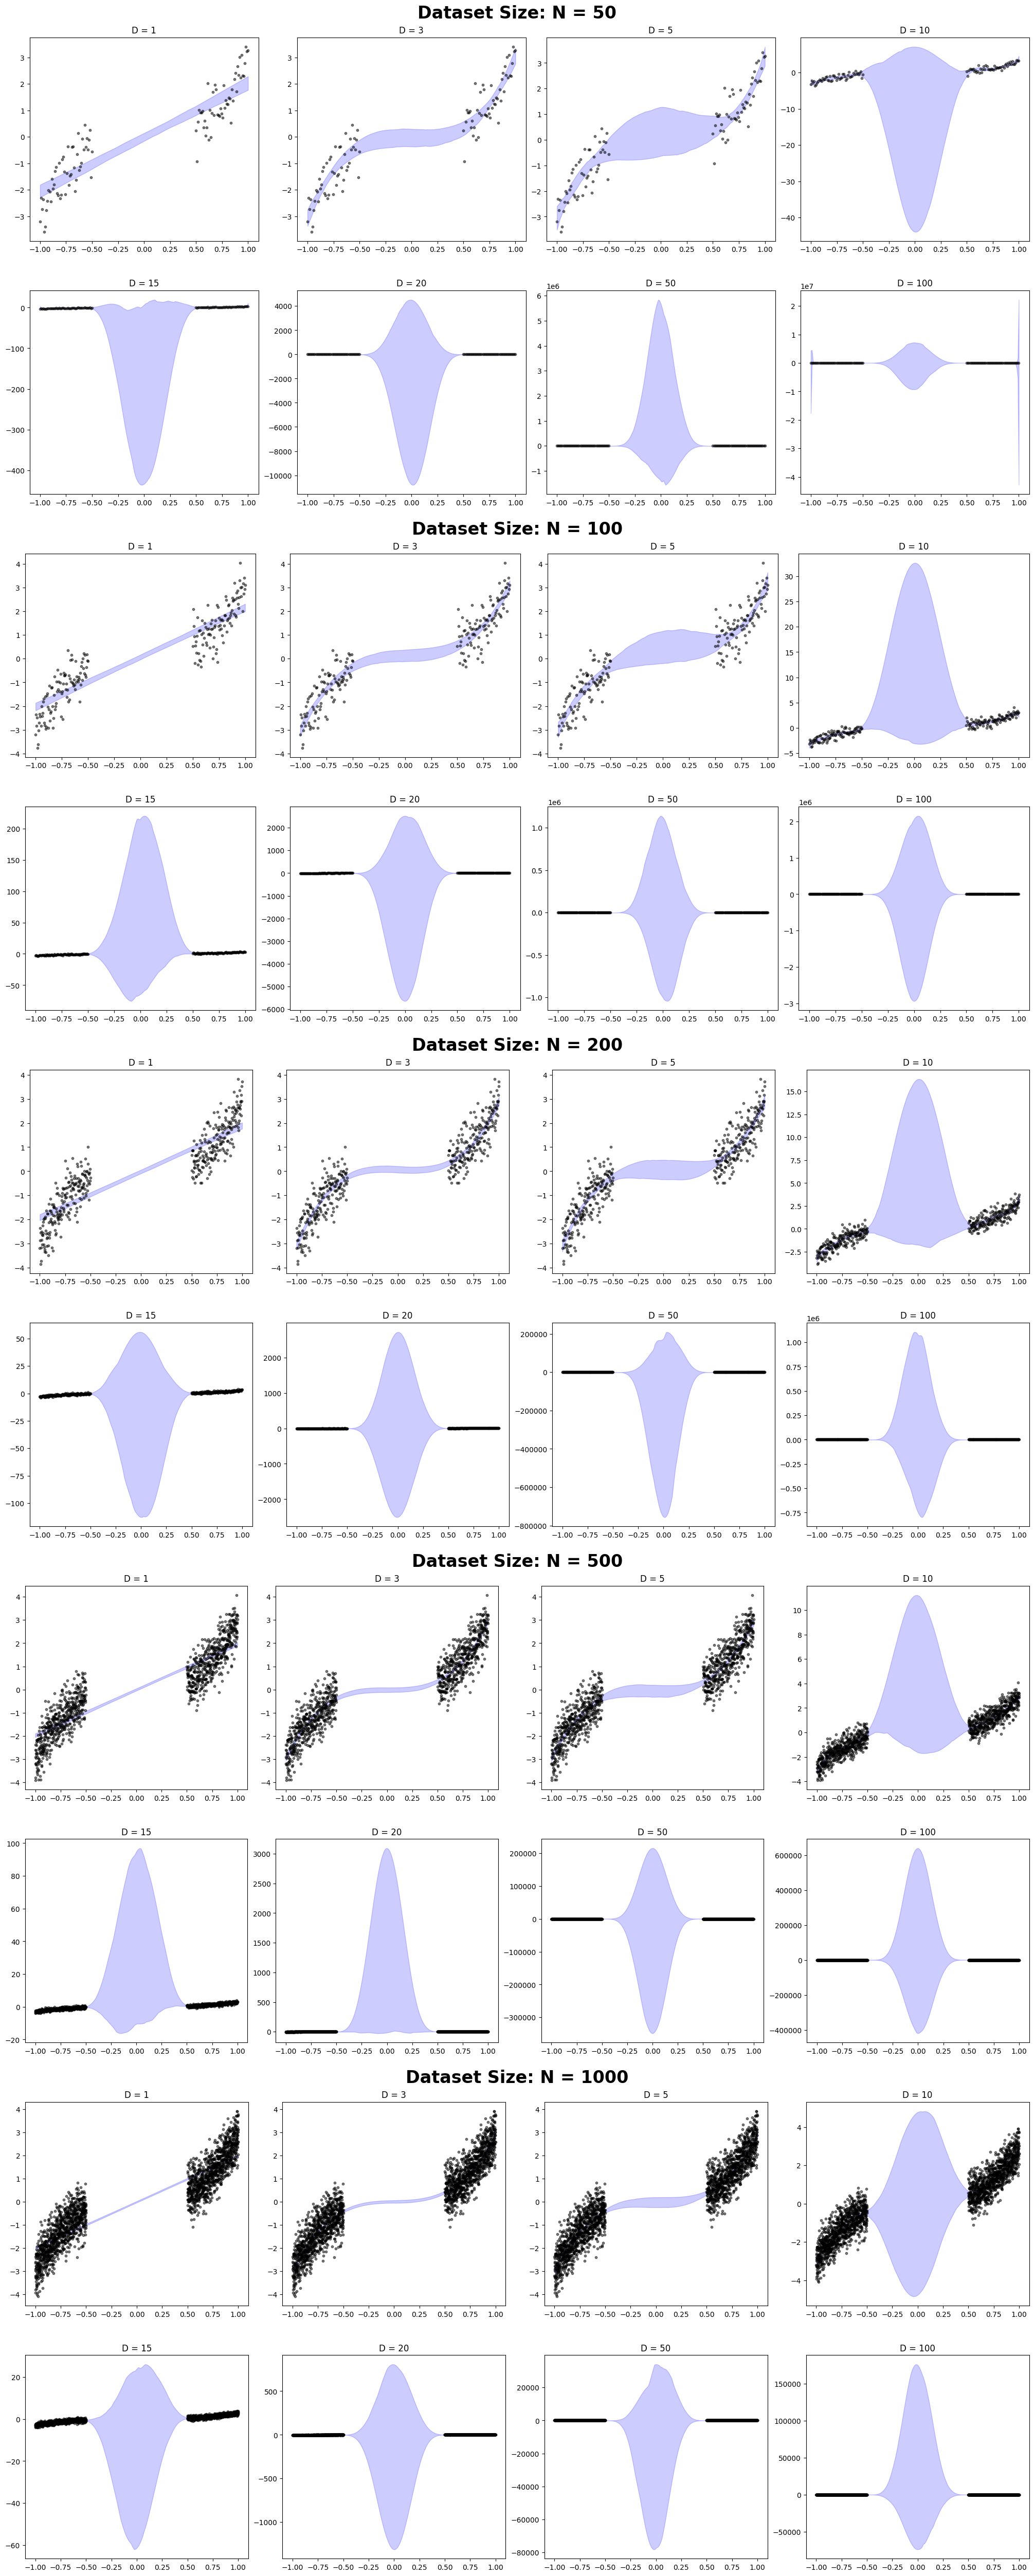

In [7]:
Ds = [1, 3, 5, 10, 15, 20, 50, 100]
nums = [50, 100, 200, 500, 1000]
num_bootstrap_models = 200

fig = plt.figure(figsize=(20, 50), constrained_layout=True)
subfigs = fig.subfigures(5, 1)
subfigs = subfigs.flatten()


for subfig, num in zip(subfigs, nums):
    subfig.suptitle(f"Dataset Size: N = {num}", fontsize=24, fontweight="bold")

    axs = subfig.subplots(2, 4)
    axs = axs.flatten()

    x_train, y_train, x_test = generate_data(number_of_points=num, noise_variance=0.3)

    seeds = rng.integers(0, 10000, size=num_bootstrap_models)

    for idx, D in enumerate(Ds):
        pred_pr2_5, pred_pr97_5 = get_95_interval_bounds(
            num_bootstrap_models, x_train, y_train, x_test, seeds, D
        )

        ax = axs[idx]
        ax.fill_between(
            x_test,
            pred_pr2_5,
            pred_pr97_5,
            alpha=0.2,
            color="blue",
            label="95% Predictive Interval",
        )
        ax.scatter(x_train, y_train, color="black", s=10, alpha=0.5)

        ax.set_title(f"D = {D}")

plt.show()

4. **(Effect of Regularization)** In practice, MLE models are nearly always trained with regularization (since they tend to overfit to the training data). Here, we will explore the effect of adding $\ell_2$ regularization to our MLE polynomial models (that is, use the `Ridge` regression model from `sklearn` after augmenting your input with polynomial features). <br><br>
For a toy dataset with 40 observations (`number_of_points=20`), plot the 95% predictive intervals for degrees $D = [1,3,5,10,15,20,50,100]$ and regularization strengths `alpha = [5e-3, 1e-2, 1e-1, 1e0, 1e1]` (you should organize these plots in a grid).<br><br>
Describe the effect of regularization on the bootstrap uncertainties. Looking at these results, are the goals of $\ell_2$ regularization and obtaining useful predictive uncertatinty estimation neccessarily well-aligned?


---
**[solution]** <br>

High regularization term makes the predictive interval smooth and stable, even when the degree D is high. However, strong regularization makes the predictive intervals on data rich and data poor regions similar, thus underestimating the uncertainty when there's few training data. Thus, the goals of $\ell_2$ regularization and obtaining useful predictive uncertainty estimation are not necessarily well-aligned.

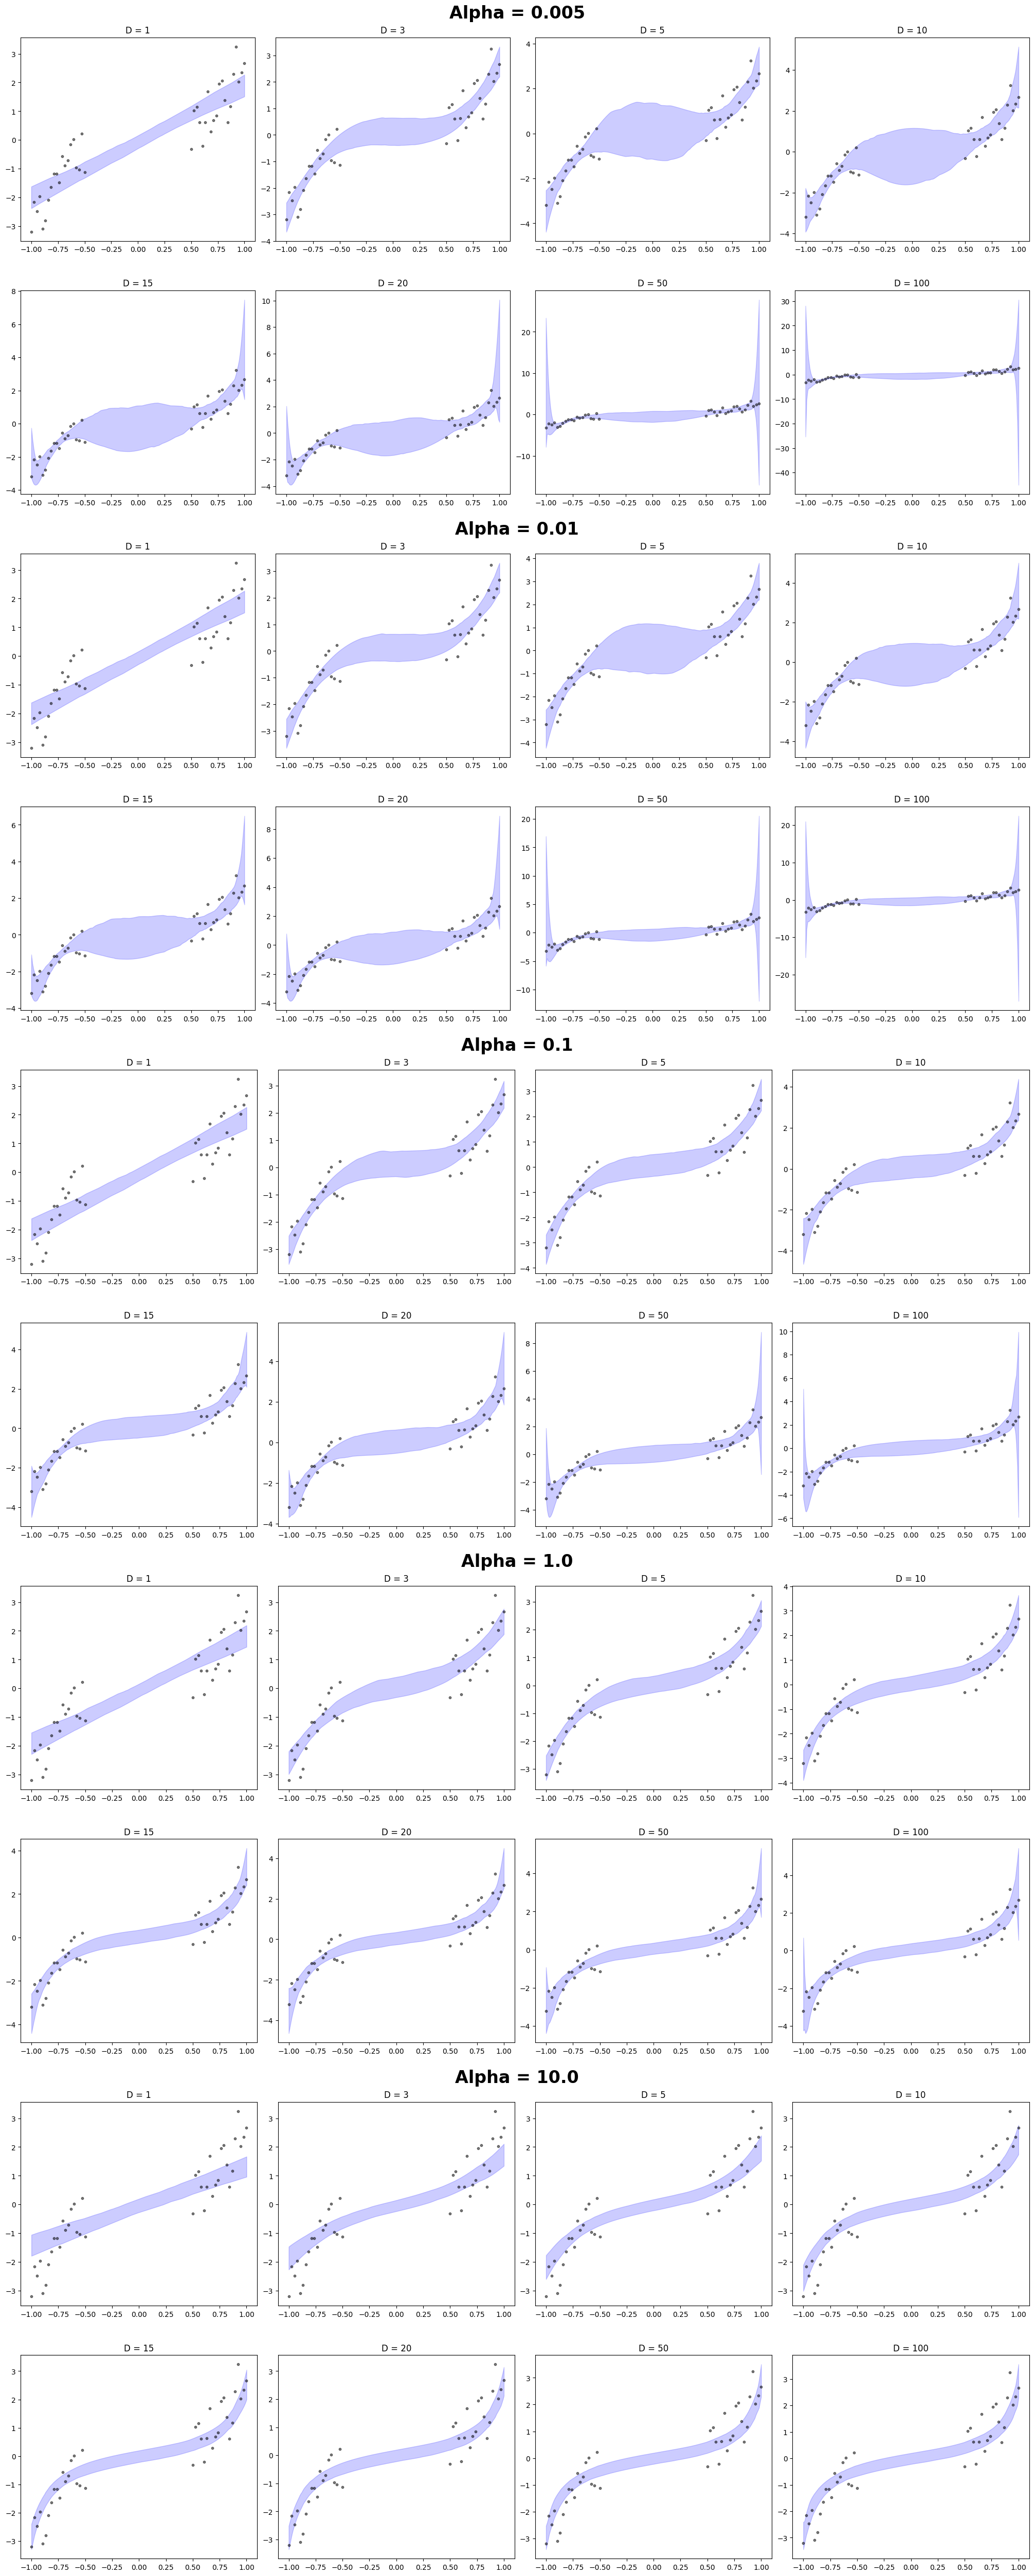

In [8]:
def fit_polynomial_ridge_regression(
    x_train, y_train, D, alpha
) -> tuple[PolynomialFeatures, Ridge]:
    x_train_reshaped = x_train.reshape(-1, 1)

    y_train_reshaped = y_train.reshape(-1, 1)

    polynomial = PolynomialFeatures(D)
    x_train_transformed = polynomial.fit_transform(x_train_reshaped)
    model = Ridge(alpha)
    model.fit(x_train_transformed, y_train_reshaped)
    return polynomial, model


x_train, y_train, x_test = generate_data(number_of_points=20, noise_variance=0.3)

fig = plt.figure(figsize=(20, 50), constrained_layout=True)
subfigs = fig.subfigures(5, 1)
subfigs = subfigs.flatten()

Ds = [1, 3, 5, 10, 15, 20, 50, 100]
alphas = [5e-3, 1e-2, 1e-1, 1e0, 1e1]
num_bootstrap_models = 200
seeds = rng.integers(0, 10000, size=num_bootstrap_models)

for subfig, alpha in zip(subfigs, alphas):
    subfig.suptitle(f"Alpha = {alpha}", fontsize=24, fontweight="bold")

    axs = subfig.subplots(2, 4)
    axs = axs.flatten()

    preds = np.empty((num_bootstrap_models, x_test.shape[0]))
    for idx, D in enumerate(Ds):
        preds = np.empty((num_bootstrap_models, x_test.shape[0]))
        pred_pr2_5, pred_pr97_5 = get_95_interval_bounds(
            num_bootstrap_models,
            x_train,
            y_train,
            x_test,
            seeds,
            D,
            fit_func=fit_polynomial_ridge_regression,
            alpha=alpha,
        )

        ax = axs[idx]
        ax.fill_between(
            x_test,
            pred_pr2_5,
            pred_pr97_5,
            alpha=0.2,
            color="blue",
            label="95% Predictive Interval",
        )
        ax.scatter(x_train, y_train, color="black", s=10, alpha=0.5)

        ax.set_title(f"D = {D}")

plt.show()

## Part II: Bayesian Polynomial Regression
In this problem, your task is to perform Bayesian polynomial regression on the toy datasets in Part I. That is, assume that the outcome $y$ can be modeled by the following process:

\begin{align}
y &= f(x) + \epsilon = w_0 + w_1x + w_2x^2 + \ldots + w_Dx^D + \epsilon, \quad \epsilon \sim N(0, 0.3)\\
w_d &\sim N(0, \alpha)
\end{align}

where $\alpha$ is a hyperparameter and must be fixed before modeling and inference begins.

1. **(Bayesian Kernel Regression)** Just as we can treat a polynomial regression model like a multi-linear regression model after ***transforming*** the input data by adding polynomial features. We can treat Bayesian polynomial regression like Bayesian linear regression on top of the transformed inputs. Formally, the map that takes an input $\mathbf{x}_n \in \mathbb{R}^{D'}$ and transforms it into a new input $\phi(\mathbf{x}_n) \in \mathbb{R}^{D}$ is called a **feature map**, $\phi: \mathbb{R}^{D'} \to \mathbb{R}^{D}$, for 1-dimensional input $x \in \mathbb{R}$, the polynomial feature map of degree $D$ is defined by
\begin{align}
\\\phi: \mathbb{R} &\to \mathbb{R}^D\\
x &\mapsto [1, x, x^2, \ldots, x^D]\\
\end{align}
<br> Thus, we can write rewrite Bayesian polynomial regression as
\begin{align}
\\y &= \mathbf{w}^\top \mathbf{x} + \epsilon, \quad \epsilon \sim {N}(0, 0.3)\\
\mathbf{w} &\sim {N}(0, \alpha I_{D\times D})\\
\end{align}
<br>Denote the $N\times D$ matrix of transformed inputs by $\Phi$, where the $n$-th row of the matrix is the $n$-th input $\mathbf{x}_n$ transformed by the feature map, $\phi(\mathbf{x}_n)$. Using this notation, write out the closed form for the posterior for Bayesian polynomial regression in terms of $\Phi$.

---
**[Solution]**<br><br>
Since the likelihood and the prior are Gaussian, the posterior will also be a Gaussian distribution.<br><br>
Likelihood: Since $y = \Phi \mathbf{w} + \epsilon$ and $\epsilon \sim N(0, \sigma^2)$ where $\sigma^2 = 0.3$, the likelihood for all $N$ observations is:$$p(\mathbf{y} | \Phi, \mathbf{w}) = \mathcal{N}(\mathbf{y} | \Phi \mathbf{w}, \sigma^2 I) \propto \exp \left( -\frac{1}{2\sigma^2} (\mathbf{y} - \Phi\mathbf{w})^\top (\mathbf{y} - \Phi\mathbf{w}) \right)$$
Prior: The weights follow a zero-mean Gaussian distribution with hyperparameter $\alpha$:$$p(\mathbf{w}) = \mathcal{N}(\mathbf{w} | 0, \alpha I) \propto \exp \left( -\frac{1}{2\alpha} \mathbf{w}^\top \mathbf{w} \right)$$<br><br>
Posterior:
$$p(\mathbf{w} | \mathbf{y}, \Phi) \propto p(\mathbf{y} | \Phi, \mathbf{w}) p(\mathbf{w})$$
-> Taking natural log for both side
$$\ln p(\mathbf{w} | \mathbf{y}, \Phi) = -\frac{1}{2\sigma^2} (\mathbf{y} - \Phi\mathbf{w})^\top (\mathbf{y} - \Phi\mathbf{w}) - \frac{1}{2\alpha} \mathbf{w}^\top \mathbf{w} + \text{constant} = -\frac{1}{2} \left[ \mathbf{w}^\top \left( \frac{1}{\sigma^2} \Phi^\top \Phi + \frac{1}{\alpha} I \right) \mathbf{w} - 2\mathbf{w}^\top \left( \frac{1}{\sigma^2} \Phi^\top \mathbf{y} \right) \right] + \text{const}$$
-> A multivariate Gaussian $\mathcal{N}(\mathbf{w} | \mathbf{\mu}_N, \Sigma_N)$ has log density $-\frac{1}{2} (\mathbf{w} - \mathbf{\mu}_N)^\top \Sigma_N^{-1} (\mathbf{w} - \mathbf{\mu}_N) = -\frac{1}{2} [\mathbf{w}^\top \Sigma_N^{-1} \mathbf{w} - 2\mathbf{w}^\top \Sigma_N^{-1} \mathbf{\mu}_N + \mathbf{\mu}_N^\top \Sigma_N^{-1} \mathbf{\mu}_N]$<br>

Thus, we got <br>
The Posterior Covariance $\Sigma_N$:$$\Sigma_N^{-1} = \frac{1}{\sigma^2} \Phi^\top \Phi + \frac{1}{\alpha} I$$ $$\Sigma_N = \left( \frac{1}{0.3} \Phi^\top \Phi + \frac{1}{\alpha} I \right)^{-1}$$
The Posterior Mean $\mathbf{\mu}_N$:$$\Sigma_N^{-1} \mathbf{\mu}_N = \frac{1}{\sigma^2} \Phi^\top \mathbf{y}$$ $$\mathbf{\mu}_N = \Sigma_N \left( \frac{1}{0.3} \Phi^\top \mathbf{y} \right)$$

<br><br>
**Closed-Form Solution** <br>

The posterior distribution for the weights $\mathbf{w}$ is a Gaussian distribution: $$p(\mathbf{w} | \mathbf{y}, \Phi) = \mathcal{N}(\mathbf{w} | \mathbf{\mu}_N, \Sigma_N)$$ 
<br>Where the parameters are defined as $$\mathbf{\mu}_N = \left( \Phi^\top \Phi + \frac{0.3}{\alpha} I \right)^{-1} \Phi^\top \mathbf{y}$$
$$\Sigma_N = 0.3 \left( \Phi^\top \Phi + \frac{0.3}{\alpha} I \right)^{-1}$$
---

2. **(Effect of Model Complexity)** For Bayesian kernel regression, you need to pre-determine the number of features (i.e. $D$) and the hyperparameter $\alpha$ in the prior. For a toy dataset with 40 observations (set number_of_points=20), visualize the 95% posterior predictive interval for $D = [1,3,5,10,15,20,50,100]$ and $\alpha = [0.1, 1, 5, 10, 100]$ (arrange these visualizations in a grid), using Bayesian polynomial regression.
<br><br>
Based on your visualizaion, describe in intuitive terms what is the role of $\alpha$ and $D$ in determining the shape of the posterior predictive uncertainty.
<br><br>
***Hint:*** Read Problem 3 before implementing Problem 2, you can implement both at the same time.
<br><br>
**Extra Credit:** When the feature map $\phi$ is a general (usually non-linear transformation), applying Bayesian linear regression on the transformed input is called **Bayesian Kernel Regression**. Choose your own non-linear feature map $\phi: \mathbb{R} \to \mathbb{R}^5$ and visualize the 95% posterior predictive interval of the Bayesian kernel regression for your choice of $\phi$ and $D = [1,3,5,10,15,20,50,100]$, $\alpha = [0.1, 1, 5, 10, 100]$. Compare the visualization to the that for Bayesian polynomial regression. Does the posterior predictive of your Bayesian kernel regression capture important properties of the posterior predictive of the Bayesian polynomial regression model?
<br><br>
**Note:** we highly recommend that you implement the following feature map:
<br><br>
\begin{align}
\phi: \mathbb{R}^{D'} &\to \mathbb{R}^D\\
\mathbf{x} &\mapsto \left[\sqrt{\frac{2}{D}} \cos(w_1^\top x + b_1), \ldots, \sqrt{\frac{2}{D}} \cos(w_D^\top x + b_D)\right]
\end{align}
<br>where $b_d \sim [0, 2\pi]$ and $w_d \sim N(0, \beta I_{D'\times D'})$ need to be randomly sampled and fixed before modeling and inference. For this exercise, we suggest setting $\beta=10$. The features generated by $\phi$ are called **Random Fourier Features**. As the number of features $D$ tends to infinity, the resulting Bayesian kernel regression model tends to an important type of Bayesian (nonparametric) model called Gaussian Process model. We will revisit the connection between Bayesian kernel regression and Gaussian processes in the latter part of the course.

---
**[solution]** <br><br>
D controls the flexibility of the model, and without regularization, high D also makes uncertainty interval wider<br>
$\alpha$ controls the strength of regularization. The lower the $\alpha$, the stronger the regularization.<br><br>

When $\phi$ generate Random Fourier Features, under certain hyperparameters, it can behave like Bayesian polynomial regression model: Upward trend, larger uncertainty in data poor region, D control flexibility, and $\alpha$ controls regularization. However, it introduces more oscillation, and the uncertainty can balloon in data poor region

Posterior Predictive Interval for Polynomial Bayesian linear model

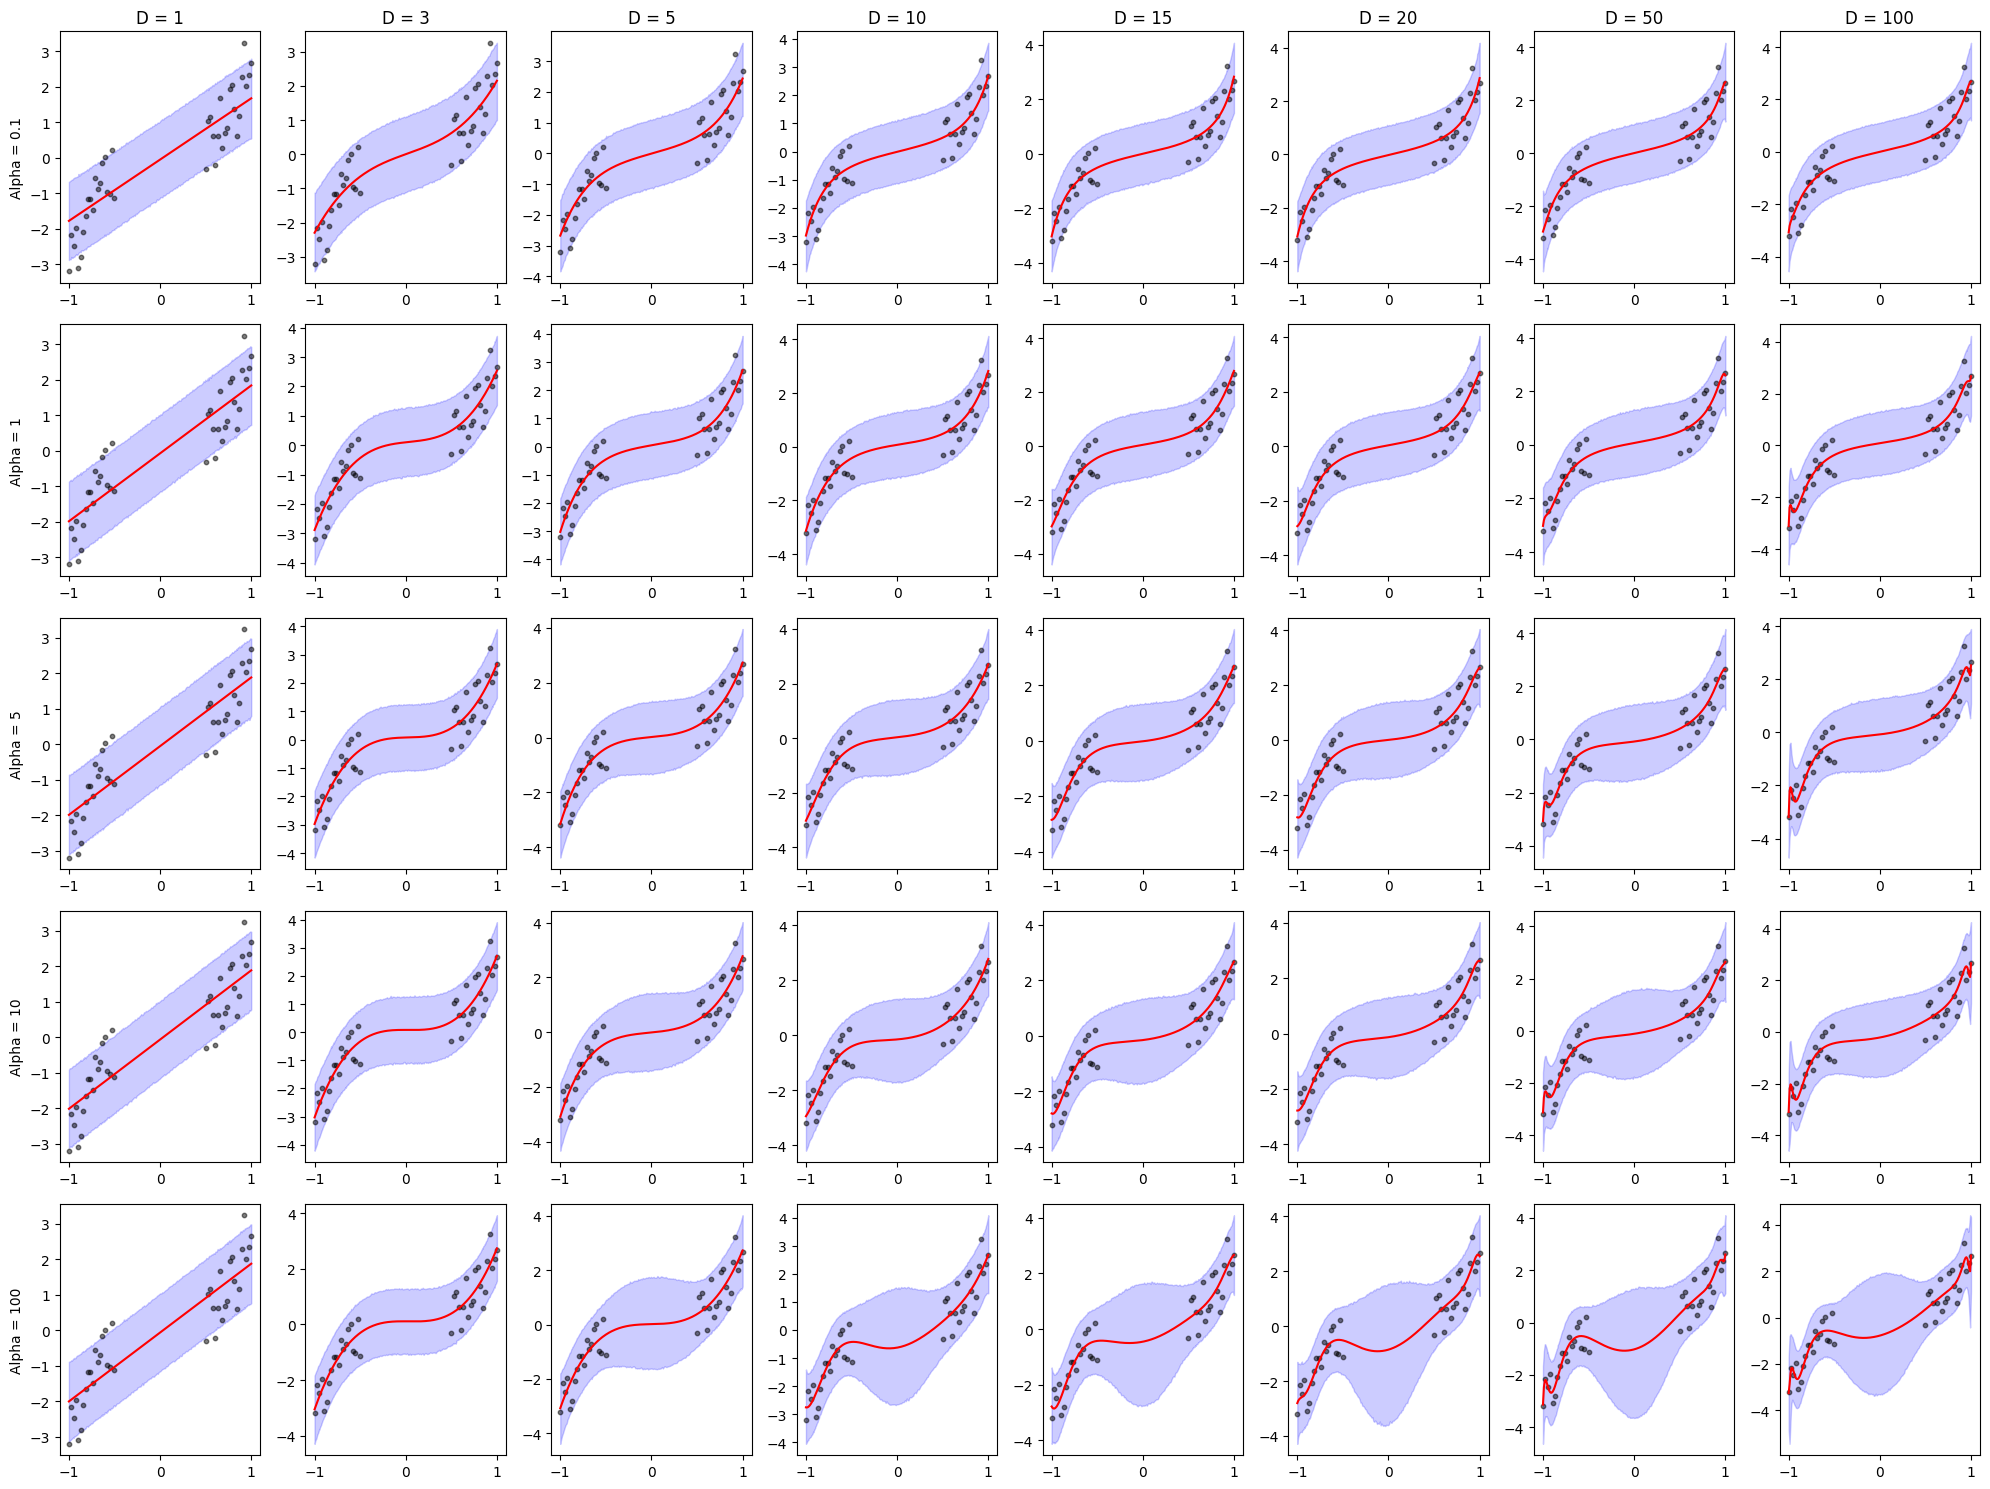

In [ ]:
x_train, y_train, x_test = generate_data(number_of_points=20, noise_variance=0.3)


def get_posterior_predictive_bounds(
    feature_mapper, alpha, x_train, y_train, x_test, noise_var=0.3
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    if hasattr(feature_mapper, "fit_transform"):
        phi_train = feature_mapper.fit_transform(x_train.reshape(-1, 1))
        phi_test = feature_mapper.transform(x_test.reshape(-1, 1))
    else:
        phi_train = feature_mapper.transform(x_train)
        phi_test = feature_mapper.transform(x_test)

    y_matrix = y_train.reshape(-1, 1)

    line_samples, pred_samples = get_posterior_samples(
        prior_var=alpha,
        noise_var=noise_var,
        x_matrix=phi_train,
        y_matrix=y_matrix,
        x_test_matrix=phi_test,
    )

    mean_pred = np.mean(line_samples, axis=0)
    lower_bound = np.percentile(pred_samples, 2.5, axis=0)
    upper_bound = np.percentile(pred_samples, 97.5, axis=0)

    return mean_pred, lower_bound, upper_bound


Ds = [1, 3, 5, 10, 15, 20, 50, 100]
alphas = [0.1, 1, 5, 10, 100]

fig, axes = plt.subplots(len(alphas), len(Ds), figsize=(20, 15))

for i, alpha in enumerate(alphas):
    for j, D in enumerate(Ds):
        feature_mapper = PolynomialFeatures(D)
        mean_pred, lower_bound, upper_bound = get_posterior_predictive_bounds(
            feature_mapper, alpha, x_train, y_train, x_test, noise_var=0.3
        )

        ax = axes[i, j]
        ax.fill_between(
            x_test,
            lower_bound,
            upper_bound,
            alpha=0.2,
            color="blue",
            label="95% Posterior Predictive Interval",
        )
        ax.plot(x_test, mean_pred, color="red", label="Mean Prediction")
        ax.scatter(x_train, y_train, color="black", s=10, alpha=0.5)

        if i == 0:
            ax.set_title(f"D = {D}")
        if j == 0:
            ax.set_ylabel(f"Alpha = {alpha}")

plt.tight_layout()
plt.show()

Posterior Predictive Interval for Bayesian model with Random Fourier Features

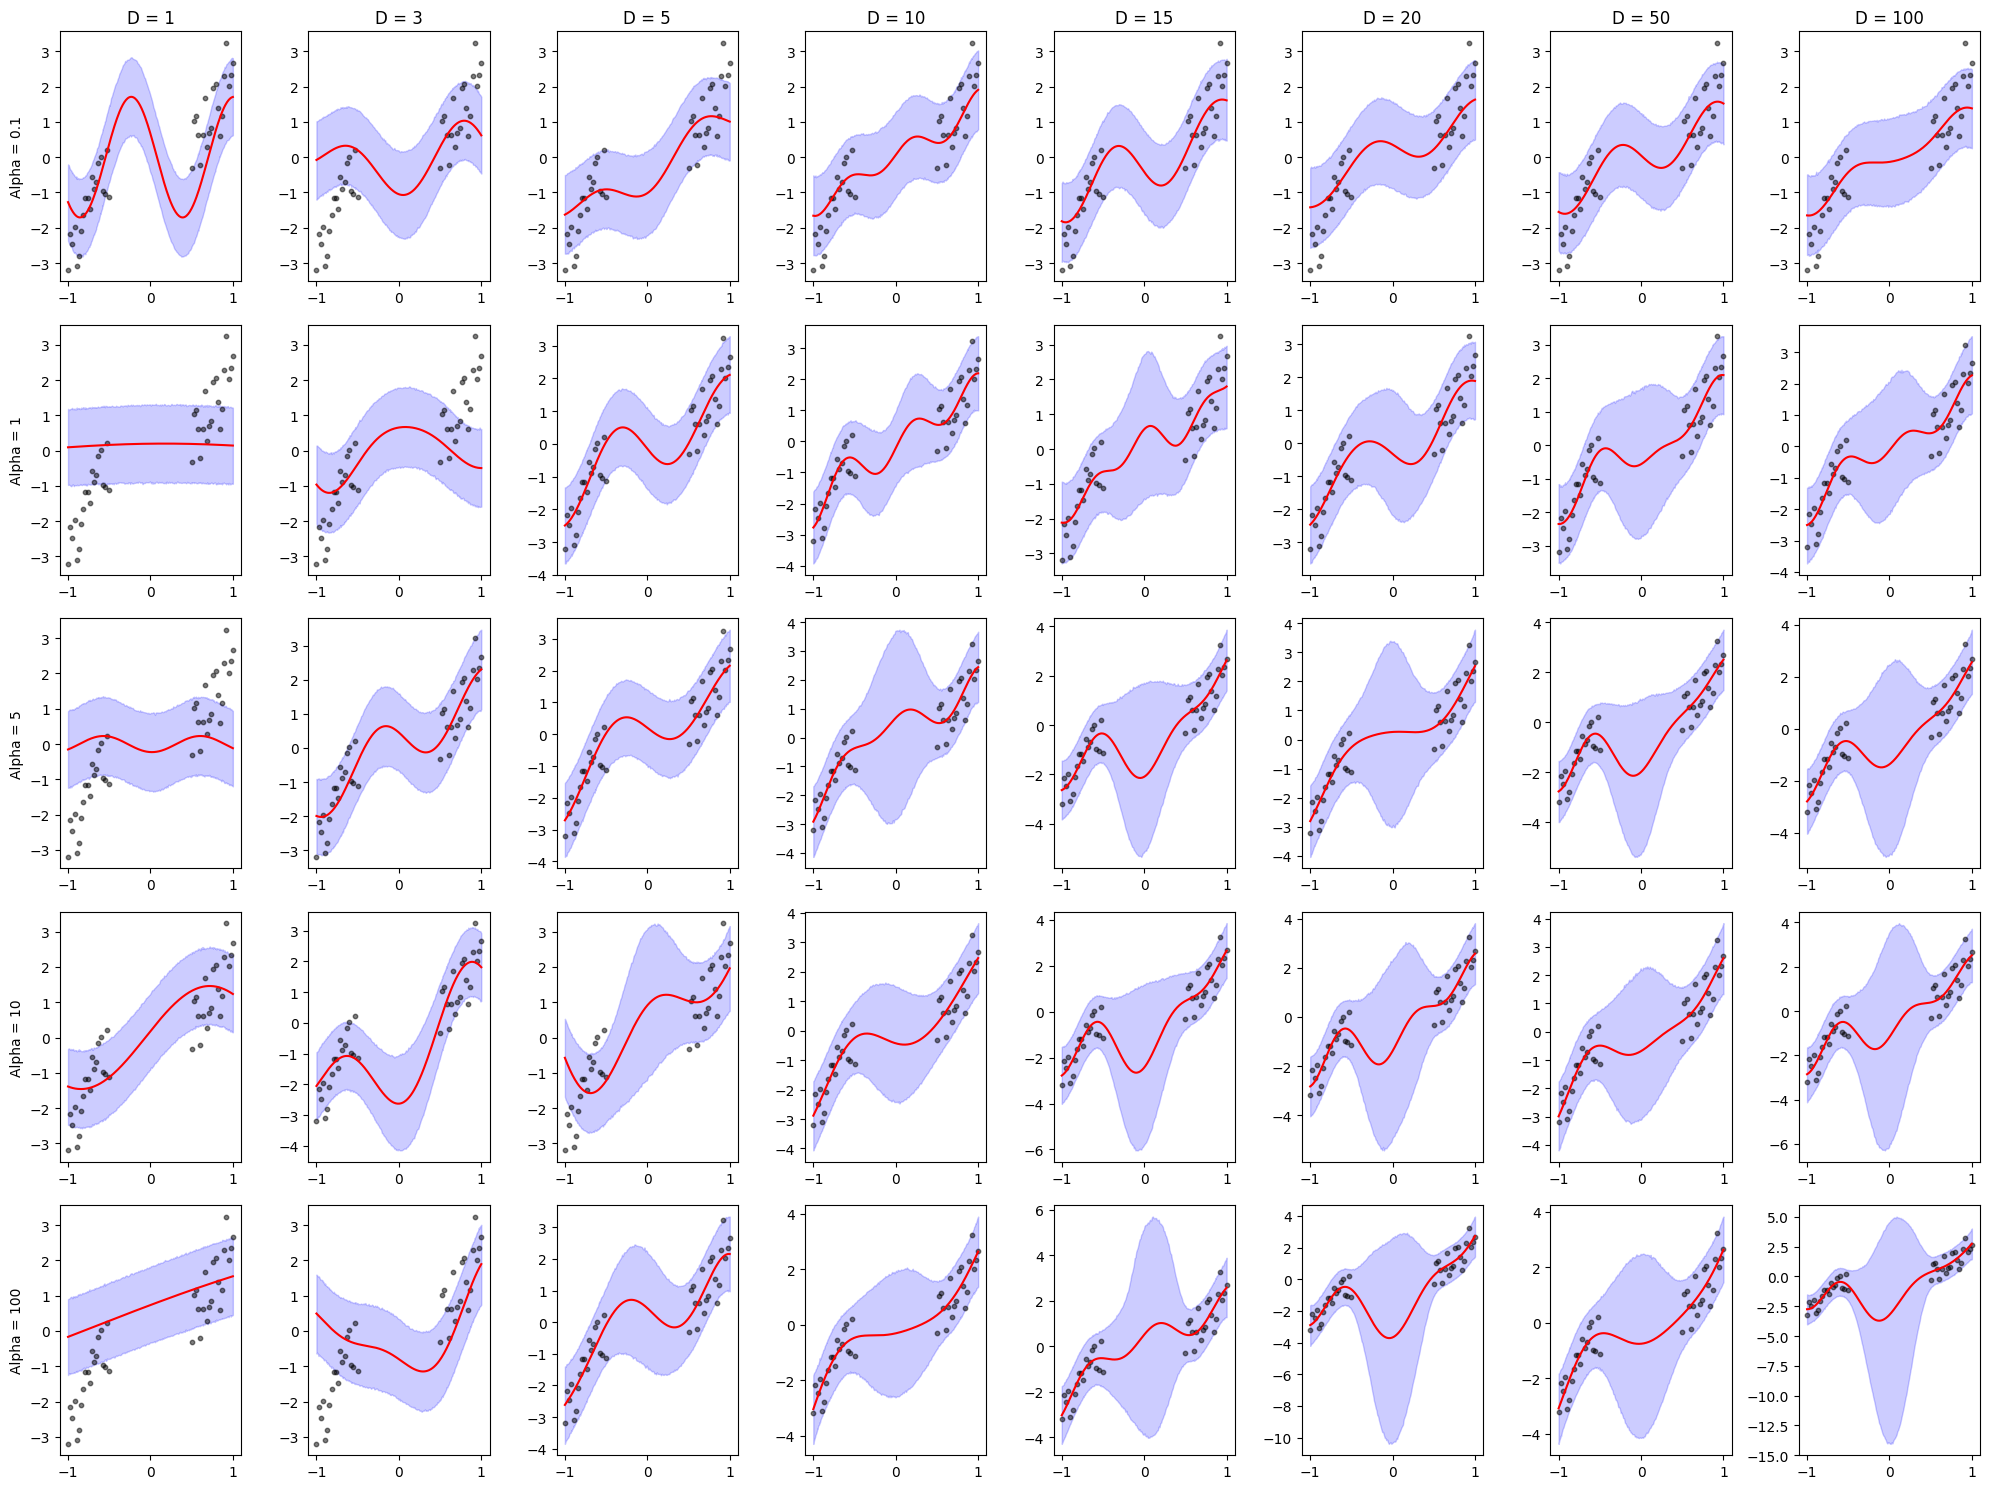

In [ ]:
class RFF_Features:
    def __init__(self, D, beta=10):
        self.D = D
        self.beta = beta
        self.w = np.random.normal(0, np.sqrt(beta), (1, D))
        self.b = np.random.uniform(0, 2 * np.pi, (1, D))

    def transform(self, x):
        x = x.reshape(-1, 1)
        phi = np.sqrt(2 / self.D) * np.cos(x @ self.w + self.b)
        return phi


fig, axes = plt.subplots(len(alphas), len(Ds), figsize=(20, 15))

for i, alpha in enumerate(alphas):
    for j, D in enumerate(Ds):
        feature_mapper = RFF_Features(D)
        mean_pred, lower_bound, upper_bound = get_posterior_predictive_bounds(
            feature_mapper, alpha, x_train, y_train, x_test, noise_var=0.3
        )

        ax = axes[i, j]
        ax.fill_between(
            x_test,
            lower_bound,
            upper_bound,
            alpha=0.2,
            color="blue",
            label="95% Posterior Predictive Interval",
        )
        ax.plot(x_test, mean_pred, color="red", label="Mean Prediction")
        ax.scatter(x_train, y_train, color="black", s=10, alpha=0.5)

        if i == 0:
            ax.set_title(f"D = {D}")
        if j == 0:
            ax.set_ylabel(f"Alpha = {alpha}")

plt.tight_layout()
plt.show()

3. **(Model Evaluation and Uncertainty Estimation)** Remember that a direct visual comparision of the 95% predictive interval against the training data is impractical! Rather, to evaluate the fit of the Bayesian model on the observed data, we evaluate the marginal log-likelihood of the data under the posterior. Given a test set $\{(\mathbf{x}^*_m, \mathbf{y}^*_m)\}$, the log posterior predictive likelihood or, simply, the **log-likelihood** is computed as:
\begin{align}
\\ \log \prod_{m=1}^M p(\mathbf{y}^*_m | \mathbf{x}^*_m, \text{Data}) &= \sum_{m=1}^M \log p(\mathbf{y}^*_m | \mathbf{x}^*_m, \text{Data})\\
&= \sum_{m=1}^M \log \int_\mathbf{w} p(\mathbf{y}^*_m | \mathbf{x}^*_m, \mathbf{w}) p(\mathbf{w}| \text{Data}) d\mathbf{w}
\end{align}
<br>i.e. the log-likelihood at a single observation $(\mathbf{x}^*_m, \mathbf{y}^*_m)$ is the log of the likelihood of the observation ***averaged over all models in the posterior***.
<br><br>
For Bayesian linear regression, with posterior ${N}(\mu_N, \Sigma_N)$ we have that
$$
p(y^*_m | x^*_m, \text{Data}) = {N}(\mu^\top\mathbf{x}^*_m, \sigma^2 + (\mathbf{x}^*_m)^\top\Sigma_N\mathbf{x}^*_m)
$$
where $\sigma^2$ is the variance of the observation noise.
<br><br>
For each choice of $D$ and $\alpha$ in Problem 2, compute the log-likelihood of the training data. Examine a models with the higher log-likelihoods and a few with lower log-likelihoods, what is the relationship between log-likelihood and predictive uncertainty? In particular, does a higher log-likelihood indicate "better" predictive uncertainty?

---
**[Solution]**<br><br>
- High log-likelihood: $D=1$ for all $\alpha$: the uncertainty interval is no difference in data rich and data poor region
- Low log-likelihood: $\alpha \ge 10$ and $D \ge 50$: the uncertainty interval is wider in data poor region.<br>
Thus, in general, a higher log-likelihood indicate a better predictive uncertainty.


In [ ]:
from scipy.stats import norm


def log_likelihood(D, alpha, x_train, y_train, noise_var=0.3):
    poly = PolynomialFeatures(D)
    Phi = poly.fit_transform(x_train.reshape(-1, 1))

    D_features = Phi.shape[1]
    prior_precision = (1.0 / alpha) * np.eye(D_features)
    likelihood_precision = (1.0 / noise_var) * (Phi.T @ Phi)

    posterior_precision = prior_precision + likelihood_precision
    Sigma_N = np.linalg.inv(posterior_precision)
    mu_N = (1.0 / noise_var) * Sigma_N @ Phi.T @ y_train.reshape(-1, 1)

    predictive_mean = Phi @ mu_N
    predictive_var = noise_var + np.sum((Phi @ Sigma_N) * Phi, axis=1)
    predictive_std = np.sqrt(predictive_var)

    log_likelihoods = norm.logpdf(
        y_train.flatten(), loc=predictive_mean.flatten(), scale=predictive_std
    )

    return np.sum(log_likelihoods)


Ds = [1, 3, 5, 10, 15, 20, 50, 100]
alphas = [0.1, 1, 5, 10, 100]
log_likelihood_matrix = np.empty((len(alphas), len(Ds)))
for i, alpha in enumerate(alphas):
    for j, D in enumerate(Ds):
        log_likelihood_matrix[i, j] = log_likelihood(
            D, alpha, x_train, y_train, noise_var=0.3
        )

pd.DataFrame(log_likelihood_matrix, index=alphas, columns=Ds)

,1,3,5,10,15,20,50,100
0.1,-50.574444,-38.467144,-35.127595,-34.635933,-35.031510,-35.066265,-34.929234,-34.918975
1.0,-48.799359,-33.658343,-33.437802,-33.651670,-33.285243,-33.183491,-32.881162,-32.405649
5.0,-48.780490,-33.154069,-33.339577,-33.131941,-32.850694,-32.881263,-31.984926,-31.858588
10.0,-48.780149,-33.127184,-33.311777,-32.982814,-32.770840,-32.788536,-31.668995,-31.640387
100.0,-48.780236,-33.116300,-33.278153,-32.528950,-32.465812,-31.938829,-31.006546,-31.016306


2. **(Bayesian versus Frequentist Uncertainty)** Compare the types of predictive uncertainties that are generated by Bayesian models and ensembles. Characterize the advantages and disadvantages of bootstrap uncertainties from an ensemble. Describe an situation where it would be better to compute bootstrap uncertainties rather than posterior predictive uncertainties from a Bayesian model.

  ***Hint:*** For example, consider situations where the data is scarce versus situations where the data is abundant; consider situations where clinicians can provide guidance on model selection using domain expertise versus situations where we would not know how patterns in the data would extrapolate to new populations of patients.

  Characterize the advantages and disadvantages of posterior predictive uncertainties from a Bayesian model. Describe an application where it is better to use these uncertainties rather than bootstrap uncertainties from an ensemble.

3. **(Measuring Uncertainty)** From your experiments, are any of the model evaluation metrics consdiered in this assignment (MSE, log-likelihood) appropriate for evaluating the quality of predictive uncertainty far away from the training data, that is, if we are concerned about the performance of models under covariate shift should we use these metrics to perform model selection?

  Do our commonly used "best practices" of training machine learning models help or hamper our ability to train models with useful predictive uncertainties?

  What would be a good metric for measuring uncertainty? How would you define "good" uncertainty in the first place?

  ***Hint:*** Can you formulate a definition of "good" uncertainty without referencing a specific down-stream task?

## Part III: Calibration and Posterior Predictive Checks
You may use these helpers as-is. Do not modify unless necessary for debugging.


In [ ]:
def reliability_diagram(probs, y_true, n_bins=10, title=None):
    """Plot a reliability diagram using confidence bins (binary case)."""
    probs = np.asarray(probs)
    y_true = np.asarray(y_true)
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    bin_ids = np.digitize(probs, bins) - 1
    bin_ids = np.clip(bin_ids, 0, n_bins - 1)

    conf = np.zeros(n_bins)
    acc = np.zeros(n_bins)
    counts = np.zeros(n_bins)

    for b in range(n_bins):
        mask = bin_ids == b
        counts[b] = mask.sum()
        if counts[b] > 0:
            conf[b] = probs[mask].mean()
            acc[b] = y_true[mask].mean()
        else:
            conf[b] = np.nan
            acc[b] = np.nan

    plt.figure()
    plt.plot([0, 1], [0, 1])
    plt.scatter(conf, acc)
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Empirical frequency")
    if title is not None:
        plt.title(title)
    plt.ylim(0, 1)
    plt.xlim(0, 1)
    plt.show()

    return conf, acc, counts


def ece_binary(probs, y_true, n_bins=10):
    """Expected Calibration Error (ECE) for binary classification."""
    probs = np.asarray(probs)
    y_true = np.asarray(y_true)

    bins = np.linspace(0.0, 1.0, n_bins + 1)
    bin_ids = np.digitize(probs, bins) - 1
    bin_ids = np.clip(bin_ids, 0, n_bins - 1)

    ece = 0.0
    n = len(y_true)
    for b in range(n_bins):
        mask = bin_ids == b
        if mask.sum() == 0:
            continue
        acc = y_true[mask].mean()
        conf = probs[mask].mean()
        ece += (mask.sum() / n) * abs(acc - conf)
    return float(ece)


def brier_binary(probs, y_true):
    probs = np.asarray(probs)
    y_true = np.asarray(y_true)
    return float(np.mean((probs - y_true) ** 2))


def temperature_scale(logits, T):
    """Binary temperature scaling on logits."""
    logits = np.asarray(logits)
    return 1 / (1 + np.exp(-logits / T))



First we will train a probabilistic classifier,
evaluate NLL, Brier, ECE, and visualize calibration using a reliability diagram.

**Dataset:** We generate a synthetic binary classification dataset.

NLL (log loss): 0.547263724664062
Brier: 0.1837454543065389
ECE: 0.0354439096800017


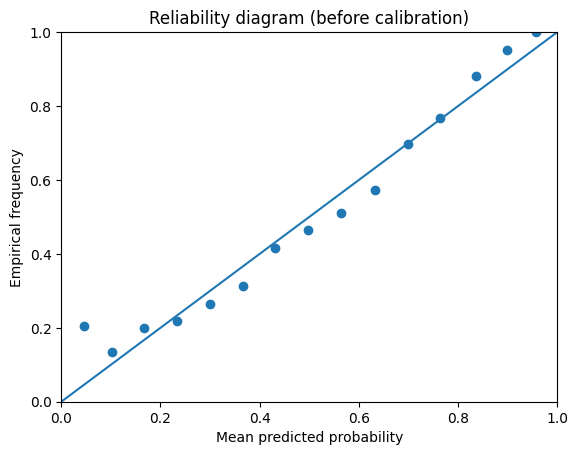

(array([0.04580185, 0.10314287, 0.16742143, 0.23347837, 0.30044462,
        0.36629914, 0.43026253, 0.49730675, 0.56474742, 0.63213458,
        0.6991298 , 0.76333738, 0.83636293, 0.8978497 , 0.95717013]),
 array([0.20454545, 0.13445378, 0.2       , 0.21938776, 0.265     ,
        0.31443299, 0.41463415, 0.46511628, 0.51075269, 0.57386364,
        0.6972973 , 0.76829268, 0.88198758, 0.95031056, 1.        ]),
 array([ 44., 119., 165., 196., 200., 194., 205., 172., 186., 176., 185.,
        164., 161., 161.,  72.]))

In [ ]:
X, y = make_classification(
    n_samples=8000,
    n_features=20,
    n_informative=10,
    n_redundant=2,
    flip_y=0.02,
    class_sep=1.0,
    random_state=0,
)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y
)

clf = Pipeline(
    [("scaler", StandardScaler()), ("lr", LogisticRegression(max_iter=1000))]
)
clf.fit(X_train, y_train)

probs = clf.predict_proba(X_test)[:, 1]

print("NLL (log loss):", log_loss(y_test, probs))
print("Brier:", brier_binary(probs, y_test))
print("ECE:", ece_binary(probs, y_test, n_bins=15))

reliability_diagram(
    probs, y_test, n_bins=15, title="Reliability diagram (before calibration)"
)



1. In the reliability diagram above, is the model **overconfident**, **underconfident**, or close to calibrated?
2. Which metric among NLL, Brier, and ECE is *most directly* a calibration metric? Briefly justify.

Write your answer in the markdown cell below.


3. We will perform temperature scaling on a held-out calibration set.

**Steps**
Split X_train into a smaller train set and a calibration set. Fit the classifier on the smaller train set. Use the calibration set to choose a temperature T that minimizes NLL. Evaluate the reliability diagram, ECE, Brier, NLL on the test set before vs after scaling. What improved and what did not?

Best T: 0.9433732216299774


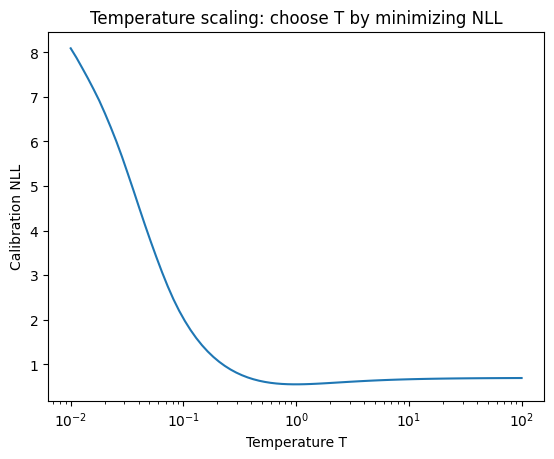

--- Test metrics ---
Before: NLL 0.5473960092006791 Brier 0.18385441500077168 ECE 0.03994141614140014
After : NLL 0.5475607231817698 Brier 0.18382349756511743 ECE 0.037917770147052325


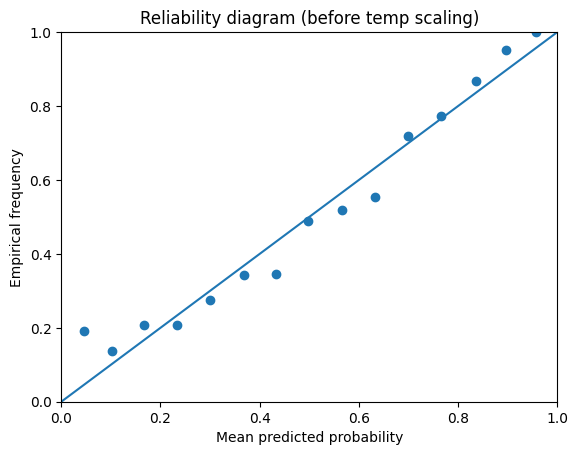

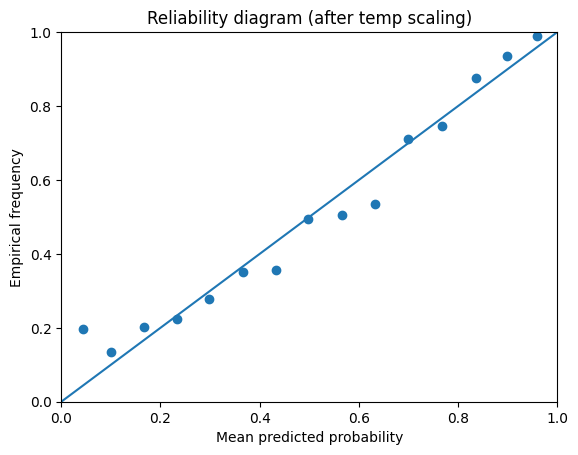

(array([0.04409992, 0.10053929, 0.16580705, 0.23258799, 0.29854342,
        0.36602708, 0.43248677, 0.49832624, 0.56498702, 0.63180947,
        0.69925629, 0.76718757, 0.83566957, 0.89846073, 0.95900905]),
 array([0.19642857, 0.13492063, 0.20231214, 0.22513089, 0.27807487,
        0.35051546, 0.35532995, 0.49382716, 0.5060241 , 0.53409091,
        0.70967742, 0.74556213, 0.875     , 0.93513514, 0.98863636]),
 array([ 56., 126., 173., 191., 187., 194., 197., 162., 166., 176., 186.,
        169., 144., 185.,  88.]))

In [ ]:
# Split train into (train_small, cal)
X_tr, X_cal, y_tr, y_cal = train_test_split(
    X_train, y_train, test_size=0.3, random_state=1, stratify=y_train
)

clf2 = Pipeline(
    [("scaler", StandardScaler()), ("lr", LogisticRegression(max_iter=1000))]
)
clf2.fit(X_tr, y_tr)

# Get logits for calibration and test
logits_cal = clf2.named_steps["lr"].decision_function(
    clf2.named_steps["scaler"].transform(X_cal)
)
logits_test = clf2.named_steps["lr"].decision_function(
    clf2.named_steps["scaler"].transform(X_test)
)

# Grid search for T
Ts = np.logspace(-2, 2, 80)
cal_nll = []
for T in Ts:
    p = temperature_scale(logits_cal, T)
    cal_nll.append(log_loss(y_cal, p))
cal_nll = np.array(cal_nll)

best_T = Ts[np.argmin(cal_nll)]
print("Best T:", best_T)

plt.figure()
plt.plot(Ts, cal_nll)
plt.xscale("log")
plt.xlabel("Temperature T")
plt.ylabel("Calibration NLL")
plt.title("Temperature scaling: choose T by minimizing NLL")
plt.show()

# Evaluate before/after on test
p_before = 1 / (1 + np.exp(-logits_test))
p_after = temperature_scale(logits_test, best_T)

print("--- Test metrics ---")
print(
    "Before: NLL",
    log_loss(y_test, p_before),
    "Brier",
    brier_binary(p_before, y_test),
    "ECE",
    ece_binary(p_before, y_test, n_bins=15),
)
print(
    "After : NLL",
    log_loss(y_test, p_after),
    "Brier",
    brier_binary(p_after, y_test),
    "ECE",
    ece_binary(p_after, y_test, n_bins=15),
)

reliability_diagram(
    p_before, y_test, n_bins=15, title="Reliability diagram (before temp scaling)"
)
reliability_diagram(
    p_after, y_test, n_bins=15, title="Reliability diagram (after temp scaling)"
)



### **Posterior Predictive Checks (PPCs) for regression**

We fit a simple probabilistic regression model and run PPC-style checks.

We assume Gaussian noise:
\[
Y \mid x \sim N(f(x), \sigma^2).
\]

We will:
- fit a ridge regression model for the mean function, and
- estimate \(\sigma\) on the training set,
then use this as a predictive distribution.

This is a simplified proxy to practice PPC mechanics.


In [ ]:
Xr, yr = make_regression(n_samples=4000, n_features=10, noise=15.0, random_state=0)
Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    Xr, yr, test_size=0.3, random_state=0
)

reg = Pipeline([("scaler", StandardScaler()), ("ridge", Ridge(alpha=1.0))])
reg.fit(Xr_train, yr_train)

mu_train = reg.predict(Xr_train)
mu_test = reg.predict(Xr_test)

# Estimate sigma from training residuals
resid = yr_train - mu_train
sigma_hat = np.std(resid)
print("Estimated sigma:", sigma_hat)


Estimated sigma: 14.72566424337125


4. Implement the average predictive negative log likelihood for a Gaussian predictive distribution: $ -\frac{1}{n}\sum_i \log N(y_i \mid \mu_i, \sigma^2). $ Return a scalar.

In [ ]:
import math


def gaussian_nll(y, mu, sigma):
    # TODO: implement average negative log likelihood for N(mu, sigma^2)
    raise NotImplementedError


# Uncomment after implementing
# print('Test NLL:', gaussian_nll(yr_test, mu_test, sigma_hat))


5. Perform a basic PPC: Simulate replicated outcomes $\tilde {y}^{(s)}\sim {N}(\mu_{test}, \sigma^2)$ for $S = 500$ replicates and compare statistics $T$ between replicated and observed outcomes. Use two statistics: $T_1$ = mean($y$); $T_2$ = variance($y$). Provide a plot showing the distribution of replicated $T_1$ and $T_2$ with the observed value marked and a short interpretation of whether the model appears to fit these statistics?

# Part IV: Conformal Prediction
We will implement split conformal prediction for regression.

Goal: produce prediction intervals $[L(x), U(x)]$ with approximate marginal coverage $(1-\alpha)$.

**Split conformal prediction for regression:**

i) Fit model on training set.

ii) On calibration set, compute residuals $r_i = |y_i - \hat{y}_i|$.

iii) Let $q$ be the $(1-\alpha)$-quantile of ${r_i}$.
Output interval for a new point $x$: $ [\hat{y}(x)-q,\ \hat{y}(x)+q]. $



In [ ]:
# Prepare data splits
Xr_tr, Xr_temp, yr_tr, yr_temp = train_test_split(Xr, yr, test_size=0.4, random_state=0)
Xr_cal, Xr_te, yr_cal, yr_te = train_test_split(
    Xr_temp, yr_temp, test_size=0.5, random_state=0
)

base = Pipeline([("scaler", StandardScaler()), ("ridge", Ridge(alpha=1.0))])
base.fit(Xr_tr, yr_tr)

pred_cal = base.predict(Xr_cal)
pred_te = base.predict(Xr_te)

resid_cal = np.abs(yr_cal - pred_cal)


def split_conformal_interval(pred, resid_cal, alpha=0.1):
    # TODO: compute q = (1-alpha)-quantile of calibration residuals
    # Return lower, upper arrays for pred
    raise NotImplementedError


# Uncomment after implementing
# L, U = split_conformal_interval(pred_te, resid_cal, alpha=0.1)
# coverage = np.mean((yr_te >= L) & (yr_te <= U))
# avg_width = np.mean(U - L)
# print('Empirical coverage:', coverage)
# print('Average interval width:', avg_width)


1. After implementing `split_conformal_interval`:

i) Compute empirical coverage for $\alpha\in\{0.05, 0.1, 0.2\}$.

ii) Report average width for each $\alpha$.

iii) Briefly interpret the tradeoff.


2. In 5–8 sentences:

Under what assumptions does split conformal guarantee coverage?

Why might those assumptions fail under covariate shift?

What is the high-level idea behind weighted conformal methods?

Write your answer below.